In [92]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import util
from IPython.display import clear_output, HTML
from torch.nn import BatchNorm1d, Dropout, Linear, Module, Parameter, ReLU, Sequential, Sigmoid, Softplus, Tanh
from torch_cluster import knn
from torch_geometric.nn import MessagePassing, GENConv
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm

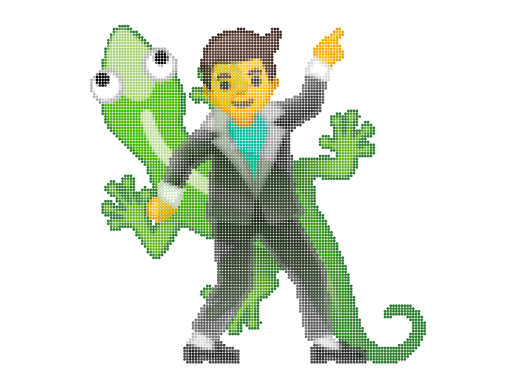

In [2]:
SOURCE = 'lizard'
TARGET = 'dancer'
SIZE = 70

plt.gca().invert_yaxis()
plt.axis('equal')
plt.axis('off')

source_img = torch.tensor(plt.imread(f'images/{SOURCE}.png'))
source_pts = torch.stack(torch.where(source_img[..., -1] >= 1.)[::-1])
source_clr = source_img[*source_pts.flip(0), :3]
plt.scatter(*source_pts, 1, source_clr)

target_img = torch.tensor(plt.imread(f'images/{TARGET}.png'))
target_pts = torch.stack(torch.where(target_img[..., -1] >= .1)[::-1])
target_clr = target_img[*target_pts.flip(0), :3]
plt.scatter(*target_pts, 1, target_clr)

plt.show()

In [72]:
INPUT_DIM = 16
HIDDEN_DIM = 128
N_LAYERS = 2

def edge_idx(x, k, r=None, loop=True):
    idx = knn(x[:, :2], x[:, :2], k if loop else k + 1)

    return idx

def activation(act='relu', **kwargs):
    if act == 'relu':
        return ReLU(**kwargs)
    elif act == 'softplus':
        return Softplus(**kwargs)
    elif act == 'sigmoid':
        return Sigmoid(**kwargs)
    elif act == 'tanh':
        return Tanh(**kwargs)
    
    raise NotImplementedError(f'Activation "{act}" not supported.')

def layer(input_dim, output_dim, bias=True, act='relu', batch_norm=False, dropout=0.):
    yield Linear(input_dim, output_dim, bias=bias)

    if batch_norm:
        yield BatchNorm1d(output_dim)

    if act is not None:
        yield activation(act)

    if dropout > 0.:
        yield Dropout(dropout)

def mlp(layers, bias=True, act='relu', final_act=None, batch_norm=False, final_norm=False, dropout=0., final_drop=0.):
    n_layers = len(layers)

    for i in range(1, n_layers):
        if i < n_layers - 1:
            yield from layer(layers[i - 1], layers[i], bias, act, batch_norm, dropout)
        else:
            yield from layer(layers[i - 1], layers[i], bias, final_act, final_norm, final_drop)

def reset_parameters(layer):
    if isinstance(layer, Linear):
        layer.reset_parameters
    
class GCN(MessagePassing):
    def __init__(self, layers, aggr='add'):
        super().__init__(aggr=aggr)

        self.net = Sequential(*list(mlp(layers, bias=False)))
        self.bias = Parameter(torch.empty(layers[-1]))

        self.reset_parameters()

    def reset_parameters(self):
        self.net.apply(reset_parameters)
        self.bias.data.zero_()

    def forward(self, x, e):
        x = self.net(x)
        n = degree(e[1], x.size(0), dtype=x.dtype)
        norm = n.pow(-.5)
        norm[norm == float('inf')] = 0
        norm = norm[e[0]]*norm[e[1]]
        y = self.propagate(e, x=x, norm=norm) + self.bias

        return y

    def message(self, x_j, norm):
        y = x_j*norm.view(-1, 1)

        return y

class NPA(Module):
    def __init__(self, input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS):
        super().__init__()

        # layers = (input_dim,) + (hidden_dim,)*(n_layers - 2) + (input_dim,)
        # self.net = GCN(layers)

        self.net1 = GENConv(input_dim, hidden_dim, num_layers=2)
        self.net2 = GENConv(hidden_dim, input_dim, num_layers=2)

    def forward(self, x, k=9, dt=1e-4):
        dx = self.net1(x, edge_idx(x[:, :2], k))
        dx = self.net2(dx.relu(), edge_idx(x[:, :2], 1))
        y = x + dt*dx
        
        return y

In [63]:
x = torch.randn(1000, 64)
x.shape

torch.Size([1000, 64])

In [ ]:
e = edge_idx(x)

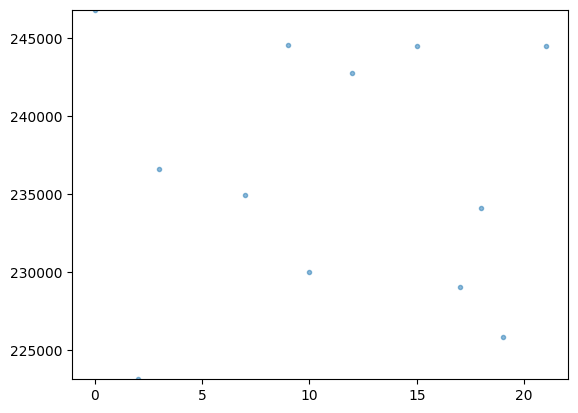

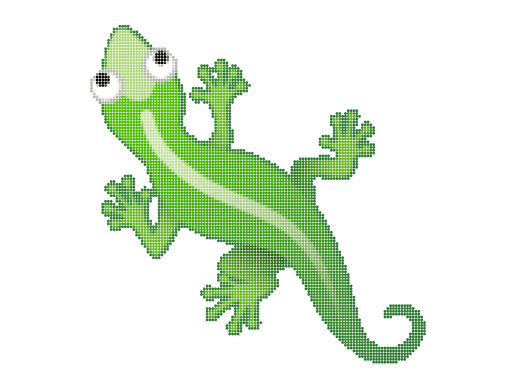

  1%|          | 23/4000 [03:06<8:58:53,  8.13s/it]


KeyboardInterrupt: 

In [73]:
N_EPOCHS = 4000
# N_STEPS = 32
LEARNING_RATE = 1e-2

channels = torch.ones(source_pts.shape[-1], INPUT_DIM - 5)
x = torch.hstack([source_pts.T, source_clr, channels])
y = torch.hstack([target_pts.T, target_clr])
model = NPA()
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)
loss_log, step_n = [], 64

def resize(x, n):
    mask = (torch.linspace(0, x.shape[-1] - 1, n) + .5).long()
    y = x[:, mask]

    return y

def loss_fn(x, y, dim_n=5, proj_n=128):
    proj = torch.normal(0., 1., (dim_n, proj_n))
    proj = proj/proj.square().sum(0).sqrt()
    x_proj = (x[:, :dim_n]@proj).T.sort()[0]
    y_proj = resize((y[:, :dim_n]@proj).T.sort()[0], x.shape[0])
    loss = (x_proj - y_proj).square().sum()/proj_n

    return loss

def show_log(log):
    clear_output(True)
    plt.plot(log, '.', alpha=.5)
    plt.ylim(np.min(log), log[0])
    plt.show()

def show_pts(pts, size=1):
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.axis('off')
    plt.scatter(*pts[:, :2].T.detach(), size, torch.clip(pts[:, 2:5].detach(), 0, 1))
    plt.show()

def backward(x, y, fn=loss_fn, **kwargs):
    optimizer.zero_grad()
    loss = fn(x, y, **kwargs)
    loss.backward()
    optimizer.step()

    return loss.item()

for i in tqdm(range(N_EPOCHS)):
    x = torch.hstack([source_pts.T, source_clr, channels])
    s = np.random.randint(64, int(step_n) + 1)

    for _ in range(s):
        x = model(x)

    step_n += (128 - 64)/N_EPOCHS
    
    loss = backward(x, y)
    loss_log.append(loss)

    if i%10 == 1:
        show_log(loss_log)
        show_pts(x)

In [70]:
N_FRAMES = 100
FRAME_RATE = 30.

with util.VideoWriter(frame_rate=FRAME_RATE) as vid:
    x = torch.hstack([source_pts.T, source_clr, channels])

    for _ in tqdm(range(N_FRAMES)):
        plt.gca().invert_yaxis()
        plt.axis('equal')
        plt.axis('off')
        plt.scatter(*x[:, :2].T.detach(), 1, torch.clip(x[:, 2:5].detach(), 0, 1))
        vid.write(util.grab_plot())
        x = model(x)

100%|██████████| 100/100 [00:07<00:00, 13.25it/s]
